# Notebook to generate model likelihood plot

This notebook requires the modeling results data, saved in
`../../cache/phys_modeling_logs/main`. This can be downloaded from the OSF
repo or can be generated by training the models yourself.

In [1]:
"""Imports."""

import json
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats as scipy_stats

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [2]:
"""Load results."""

np.random.seed(42)  # For reproducibility
torch.manual_seed(42)  # For reproducibility

BASE_RESULTS_DIR = Path("../../../cache/modeling/main")
SEEDS = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
MODEL_TO_NAME = {
    "ring_slot_partition": "Slot",
    "ring_switching": "Switching",
    "ring_gain": "Gain",
}
MODEL_ORDER = ["Slot", "Switching", "Gain"]
MODEL_DIRS = [
    "ring_slot_partition",
    "ring_switching",
    "ring_gain",
]
SUBJECT_SESSIONS = [
    ("Elgar", "2022-09-06"),
    ("Elgar", "2022-09-07"),
    ("Elgar", "2022-09-09"),
    ("Elgar", "2022-09-10"),
    ("Elgar", "2022-09-11"),
    ("Elgar", "2022-09-12"),
    ("Elgar", "2022-09-13"),
    ("Elgar", "2022-09-14"),
    ("Elgar", "2022-09-15"),
    ("Elgar", "2022-09-20"),
    ("Perle", "2022-06-07"),
    ("Perle", "2022-06-09"),
    ("Perle", "2022-06-10"),
    ("Perle", "2022-06-11"),
    ("Perle", "2022-06-12"),
    ("Perle", "2022-06-13"),
    ("Perle", "2022-06-14"),
    ("Perle", "2022-06-15"),
    ("Perle", "2022-06-16"),
    ("Perle", "2022-06-19"),
]

# Bootstrap function
def _compute_bootstrap_probs(ll_per_model, trials_per_bootstrap=100, n_bootstrap=1000):
    """Compute bootstrap probabilities."""
    # Get log-likelihoods
    models = list(ll_per_model.keys())
    ll_per_model_array = np.array([ll_per_model[k] for k in models])
    
    # Compute bootstrap probabilities
    probs_per_bootstrap = []
    for _ in range(n_bootstrap):
        trials = np.random.choice(
            ll_per_model_array.shape[1],
            size=trials_per_bootstrap,
            replace=True,
        )
        ll_bootstrap = np.sum(ll_per_model_array[:, trials], axis=1)
        ll_bootstrap = ll_bootstrap - ll_bootstrap.min()
        probs = np.exp(ll_bootstrap) / np.sum(np.exp(ll_bootstrap))
        probs_per_bootstrap.append(probs)
    
    # Return mean over bootstraps
    probs_per_bootstrap = {
        k: [x[i] for x in probs_per_bootstrap]
        for i, k in enumerate(models)
    }
    return probs_per_bootstrap

# Get data
data_df = {
    "subject": [],
    "session": [],
    "num_neurons": [],
    "seed": [],
    "model": [],
    "prob": [],
}
for subject, session in SUBJECT_SESSIONS:
    print(subject, session)
    for seed in SEEDS:
        # Get data per model
        test_ll_stats_per_model = {}
        num_neurons_per_model = {}
        valid = True
        for model_dir in MODEL_DIRS:
            log_dir = BASE_RESULTS_DIR / model_dir / subject / session / str(seed)
            if not log_dir.exists():
                raise ValueError(f"Log directory {log_dir} does not exist.")
            stop_step = json.load(open(log_dir / "stop_step" / "step.json"))
            # if stop_step < 1200:
            #     valid = False
            test_ll_stats = json.load(open(log_dir / "stop_step" / "eval_stats.json"))
            test_ll_stats_per_model[model_dir] = test_ll_stats
            num_neurons = json.load(open(log_dir / "test_metrics.json"))[0]["num_neurons"]
            num_neurons_per_model[model_dir] = num_neurons
        # if not valid:
        #     continue
        
        # Validate have same trials per unit for each model
        trials_per_unit_str = {
            k: str(v["trials_per_unit"])
            for k, v in test_ll_stats_per_model.items()
        }
        trials_per_unit = set(trials_per_unit_str.values())
        if len(trials_per_unit) != 1:
            raise ValueError(f"Trials per unit mismatch: {trials_per_unit_str}")
        
        # Compute probabilities per model
        ll_per_model = {}
        for model, test_ll_stats in test_ll_stats_per_model.items():
            flat_ll = []
            for x in test_ll_stats["ll_per_unit"]:
                flat_ll.extend(x)
            ll_per_model[model] = flat_ll
        bootstrap_probs = _compute_bootstrap_probs(ll_per_model)
        for model, probs in bootstrap_probs.items():
            n_probs = len(probs)
            data_df["subject"].append(subject)
            data_df["session"].append(session)
            data_df["num_neurons"].append(num_neurons_per_model[model])
            data_df["seed"].append(seed)
            data_df["model"].append(MODEL_TO_NAME[model])
            data_df["prob"].append(np.mean(probs))

# Convert to dataframe
data_df = pd.DataFrame(data_df)

Elgar 2022-09-06
Elgar 2022-09-07
Elgar 2022-09-09
Elgar 2022-09-10
Elgar 2022-09-11
Elgar 2022-09-12
Elgar 2022-09-13
Elgar 2022-09-14
Elgar 2022-09-15
Elgar 2022-09-20
Perle 2022-06-07
Perle 2022-06-09
Perle 2022-06-10
Perle 2022-06-11
Perle 2022-06-12
Perle 2022-06-13
Perle 2022-06-14
Perle 2022-06-15
Perle 2022-06-16
Perle 2022-06-19


In [3]:
for session in data_df.session.unique():
    df_session = data_df[data_df.session == session]
    subject = df_session.subject.iloc[0]
    num_neurons = df_session.num_neurons.iloc[0]
    print(f"Session: {session}, Subject: {subject}, Num Neurons: {num_neurons}")

Session: 2022-09-06, Subject: Elgar, Num Neurons: 17
Session: 2022-09-07, Subject: Elgar, Num Neurons: 11
Session: 2022-09-09, Subject: Elgar, Num Neurons: 31
Session: 2022-09-10, Subject: Elgar, Num Neurons: 14
Session: 2022-09-11, Subject: Elgar, Num Neurons: 9
Session: 2022-09-12, Subject: Elgar, Num Neurons: 11
Session: 2022-09-13, Subject: Elgar, Num Neurons: 21
Session: 2022-09-14, Subject: Elgar, Num Neurons: 27
Session: 2022-09-15, Subject: Elgar, Num Neurons: 21
Session: 2022-09-20, Subject: Elgar, Num Neurons: 15
Session: 2022-06-07, Subject: Perle, Num Neurons: 7
Session: 2022-06-09, Subject: Perle, Num Neurons: 95
Session: 2022-06-10, Subject: Perle, Num Neurons: 113
Session: 2022-06-11, Subject: Perle, Num Neurons: 114
Session: 2022-06-12, Subject: Perle, Num Neurons: 73
Session: 2022-06-13, Subject: Perle, Num Neurons: 62
Session: 2022-06-14, Subject: Perle, Num Neurons: 44
Session: 2022-06-15, Subject: Perle, Num Neurons: 32
Session: 2022-06-16, Subject: Perle, Num Neuro

In [4]:
"""Print statistics."""

# For each subject, print mean probability per model and number of sessions
# where gain model is best
for subject in data_df["subject"].unique():
    print(f"Subject: {subject}")
    subject_df = data_df[data_df["subject"] == subject]
    
    # Mean probabilities per model
    mean_probs = subject_df.groupby("model")["prob"].mean()
    print("Mean probabilities per model:")
    print(mean_probs)
    
    # Number of sessions where gain model is best
    gain_best = []
    for session in subject_df["session"].unique():
        session_df = subject_df[subject_df["session"] == session]
        # Take mean probability per model
        session_probs = session_df.groupby("model")["prob"].mean()
        # Check if Gain model is best
        gain_best.append(session_probs.idxmax() == "Gain")
    gain_best_count = sum(gain_best)
    print(f"Number of sessions where Gain model is best: {gain_best_count} / {len(gain_best)}\n")


Subject: Elgar
Mean probabilities per model:
model
Gain         0.382799
Slot         0.311215
Switching    0.305986
Name: prob, dtype: float64
Number of sessions where Gain model is best: 9 / 10

Subject: Perle
Mean probabilities per model:
model
Gain         0.569743
Slot         0.221950
Switching    0.208307
Name: prob, dtype: float64
Number of sessions where Gain model is best: 10 / 10



/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_15561/3317933523.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.08232202558909871' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mean_per_session_df.loc[j, "model"] += _add_x_jitter(
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_15561/3317933523.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_15561/3317933523.py:116: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/

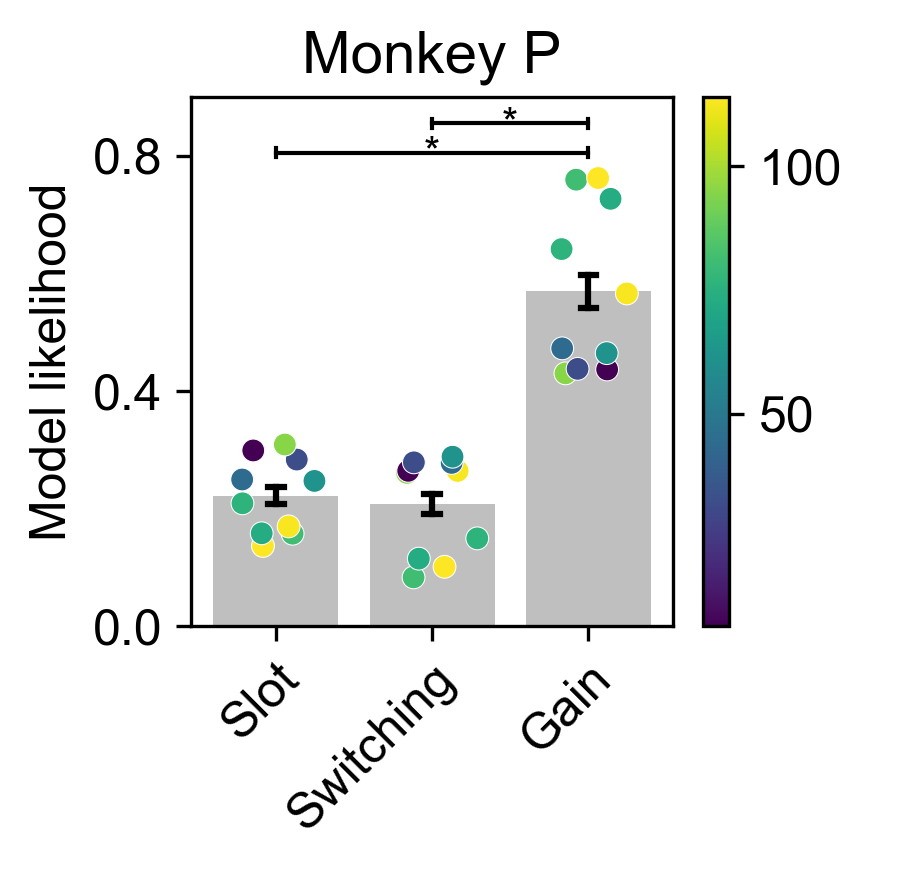

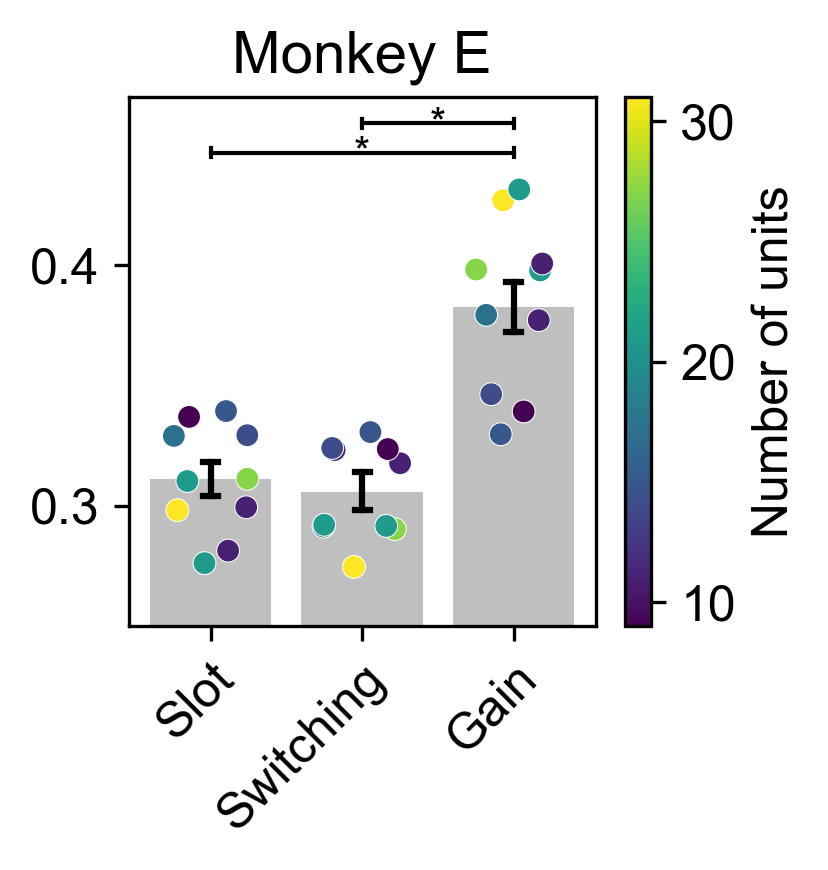

In [44]:
"""Plot."""

np.random.seed(0) # For reproducibility

def _add_x_jitter(row, y_safezone, parity, jitter=0.15, jitter_safezone=0.15):
    """Add x-jitter to row."""
    sample = np.random.uniform(0, jitter)
    prob = row["prob"]
    if prob > y_safezone[0] and prob < y_safezone[1]:
        sample += jitter_safezone
    if parity == 0:
        sample = -sample
    return sample

min_neurons = data_df["num_neurons"].min()
max_neurons = data_df["num_neurons"].max()
for subject in ["Perle", "Elgar"]:
    fig_width = 3.1 if subject == "Perle" else 2.85
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, 3.))
    # Y ticks and limits
    if subject == "Perle":
        y_ticks = [0., 0.4, 0.8]
        colorbar_y_ticks = [50, 100]
        ylim = [0, 0.9]
    else:
        y_ticks = [0.3, 0.4]
        colorbar_y_ticks = [10, 20, 30]
        ylim = [0.25, 0.47]

    ax.set_title(f"Monkey {subject[0]}")
    subject_df = data_df[data_df.subject == subject]
    
    # Barplot of probabilities
    sns.barplot(
        data=subject_df,
        ax=ax,
        x="model",
        y="prob",
        zorder=0,
        color=(0.75, 0.75, 0.75),
        err_kws={'color': 'k', 'linewidth': 1.5},
        capsize=0.1,
    )
    
    # Add scatterplot of means
    mean_per_session_df = subject_df.groupby(["model", "session"])[["num_neurons", "prob"]].mean().reset_index()
    mean_per_session_df = mean_per_session_df.sort_values(by=["model", "prob"]).reset_index(drop=True)
    mean_per_session_df["model"] = mean_per_session_df["model"].map(
        {name: i for i, name in enumerate(MODEL_ORDER)})
    for i in range(3):
        y_mean = np.mean(mean_per_session_df[mean_per_session_df["model"] == i]["prob"])
        y_ci = scipy_stats.sem(mean_per_session_df[mean_per_session_df["model"] == i]["prob"]) * 1.96
        y_safezone = (y_mean - y_ci - 0.01, y_mean + y_ci + 0.01)
        for j, row in mean_per_session_df[mean_per_session_df["model"] == i].iterrows():
            parity = j % 2
            mean_per_session_df.loc[j, "model"] += _add_x_jitter(
                row,
                y_safezone,
                parity,
            )
    sns.scatterplot(
        data=mean_per_session_df,
        x="model",
        y="prob",
        hue="num_neurons",
        ax=ax,
        linewidth=0.25,
        legend=False,
        palette="viridis",
        s=30,
    )
    
    # Plot significance brackets with stars
    count = 0
    for i, model1 in enumerate(MODEL_DIRS):
        for j, model2 in enumerate(MODEL_DIRS):
            if i >= j:
                continue
            model1_name = MODEL_TO_NAME[model1]
            model2_name = MODEL_TO_NAME[model2]
            model1_probs = subject_df[subject_df["model"] == model1_name]["prob"]
            model2_probs = subject_df[subject_df["model"] == model2_name]["prob"]
            model1_probs = model1_probs[np.isfinite(model1_probs)]
            model2_probs = model2_probs[np.isfinite(model2_probs)]
            # Perform t-test
            t, p = scipy_stats.ttest_ind(model1_probs, model2_probs)
            if p < 0.01:
                # Add significance brackets
                count += 1
                y_spread = ylim[1] - ylim[0]
                y = ylim[1] - 0.16 * y_spread + 0.055 * y_spread * count
                ax.plot([i, j], [y, y], 'k-', lw=1)
                bracket_hw = 0.008 * y_spread
                ax.plot([i, i], [y - bracket_hw, y + bracket_hw], 'k-', lw=1)
                ax.plot([j, j], [y - bracket_hw, y + bracket_hw], 'k-', lw=1)
                ax.text((i + j) / 2, y - 0.04 * y_spread, "*", ha='center', va='bottom', color='k')

    if subject == "Perle":
        ax.set_ylabel('Model likelihood')
    else:
        ax.set_ylabel('')
    ax.set_ylim(ylim)
    ax.set_yticks(y_ticks)
    ax.set_xlabel('')
    
    # Rotate x-tick labels
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor',
    )

    # Add colorbar for number of neurons
    hues = mean_per_session_df["num_neurons"]
    cmap = plt.cm.get_cmap('viridis')
    norm = plt.Normalize(vmin=subject_df.num_neurons.min(), vmax=subject_df.num_neurons.max())
    hues = cmap(norm(hues))
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(sm, ax=ax, ticks=colorbar_y_ticks)
    if subject == "Elgar":
        cbar.set_label("Number of units")
    else:
        cbar.set_label(" ", labelpad=-2)

    # Save figure
    fig.tight_layout()
    fig.savefig(f"./model_likelihoods_{subject}.pdf", bbox_inches='tight', pad_inches=0.02)